# Calculate Stats on Tuning Distributions

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as posthoc
from statsmodels.stats.multitest import multipletests
from hmmlearn import hmm

sys.path.insert(0, os.path.abspath(r'C:/Users/matt/repos/prey_capture/'))
import functions_plotting as fp

In [90]:
def h5_to_dict(filepath):
    with pd.HDFStore(filepath, 'r') as store:
        keys = store.keys()
        data = {key[1:]: store[key] for key in keys}
    return data


def kruskal_w_dunn(data, nan_policy='omit', alpha=0.05):
    statistic, p_val = stats.kruskal(*data, nan_policy=nan_policy)
    dunn_test = posthoc.posthoc_dunn([*data], p_adjust='holm')
    return p_val, dunn_test


def mannwhitneyu_w_bonferroni(data, nan_policy='omit', alpha=0.05):
    statistic, p_val = stats.mannwhitneyu(*data, nan_policy=nan_policy)
    reject, p_val_corrected, _, _ = multipletests(p_val, alpha=alpha, method='holm')
    return p_val, p_val_corrected


def wilcoxon_w_bonferroni(data, nan_policy='omit', alpha=0.05):
    statistic, p_val = stats.wilcoxon(*data, nan_policy=nan_policy)
    reject, p_val_corrected, _, _ = multipletests(p_val, alpha=alpha, method='holm')
    return p_val, p_val_corrected


def sample_df(data1, data2):
    df1 = data1.dropna()
    df2 = data2.dropna() 

    if len(df1) > len(df2):
        df1 = df1.sample(len(df2), replace=True)
    elif len(df2) > len(df1):
        df2 = df2.sample(len(df1), replace=True)
    else:
        pass

    return df1, df2


def bootstrap_tests(datasets, key, tuning_kind, method, n_iters=10000, alpha=0.05, bootstrap_all=False):
    data = [ds[key][tuning_kind].dropna() for ds in datasets]

    # First run the test on the raw data
    if 'wilcoxon' in method.__name__:
        raw_test = method(sample_df(*data), alpha=alpha)
    elif 'mannwhitneyu' in method.__name__:
        raw_test = method(data, alpha=alpha)
    else:
        raw_test = method(data, alpha=alpha)

    # Now run the bootstrapping
    p_vals = np.zeros(n_iters)
    p_vals_corrected = []

    sample_size = len(max(data, key=len))

    # Run bootstrap
    for i in range(n_iters):

        if bootstrap_all:
            sample_data = [d.sample(sample_size, replace=True) for d in data]
            # sample_data1  = data2.sample(sample_size, replace=True)
        else:
            sample_data = [data[0]] + [d.sample(sample_size, replace=True) for d in data[1:]]
            
        p_val, p_val_corrected = method(sample_data, alpha=alpha)
        p_vals[i] = p_val
        p_vals_corrected.append(p_val_corrected)

    # 95% confidence interval
    ci = stats.t.interval(0.95, len(p_vals) - 1, loc=np.nanmean(p_vals), scale=stats.sem(p_vals, nan_policy='omit'))

    if method == kruskal_w_dunn:
        ci_corrected = None
    else:
        ci_corrected = stats.t.interval(0.95, len(p_vals_corrected) - 1, loc=np.nanmean(p_vals_corrected), scale=stats.sem(p_vals_corrected, nan_policy='omit'))

    return raw_test, (p_vals, ci), (p_vals_corrected, ci_corrected)


def plot_bootstrap_distributions(data):
    # Plot the bootstrap distributions
    num_ds = len(data)
    cols = 3
    rows = num_ds//cols + 1
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

    for i, (ds, ax) in enumerate(zip(data, axes.ravel())):

        raw_test = ds[0]
        bootstrap_tests = ds[1]
        corrected_bootstrap_tests = ds[2]

        ax.hist(bootstrap_tests[0], bins=20)
        ax.axvline(np.percentile(bootstrap_tests[0], 95), 0, 50, color='r')
        ax.axvline(bootstrap_tests[1][0], 0, 50, color='g')
        ax.axvline(bootstrap_tests[1][1], 0, 50, color='g')
        ax.axvline(raw_test[0], 0, 100, color='k')


    return fig, axes

In [19]:
basedir = r"E:\thesis\figures\WF_Figures"
still_or_all = 'full'
main_exp_path = os.path.join(basedir, still_or_all, r"multi_normal_ALL\stats.hdf5")
control_light_path  = os.path.join(basedir, still_or_all, r"control_normal_ALL\stats.hdf5")
control_dark_path = os.path.join(basedir, still_or_all, r"control_dark_ALL\stats.hdf5")
repeat_fixed_path = os.path.join(basedir, still_or_all, r"repeat_normal_VWheelWF\stats.hdf5")
repeat_free_path = os.path.join(basedir, still_or_all, r"repeat_normal_VTuningWF\stats.hdf5")

In [4]:
main_exp_data = h5_to_dict(main_exp_path)
control_light_data = h5_to_dict(control_light_path)
control_dark_data = h5_to_dict(control_dark_path)
repeat_fixed_data = h5_to_dict(repeat_fixed_path)
repeat_free_data = h5_to_dict(repeat_free_path)

# Visual Tuning

In [94]:
method = kruskal_w_dunn
bootstrap_iters = 1000

## Frac Visual Tuning - Fixed to Free

### Kruskal-Wallis

In [88]:
# Do a Kruskal-Wallis test with posthoc Dunn test for multiple comparisons

# General
exp_fixed_free_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].general, 
                                              main_exp_data['frac_vis_resp_free'].general))
print('Fixed vs Free General:', exp_fixed_free_gen)

# Visual
exp_fixed_free_vis = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].visual, 
                                              main_exp_data['frac_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_vis_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].visual_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].visual_no_gen))
print('Fixed vs Free Visual No Gen:', exp_fixed_free_vis_no_gen)

exp_fixed_vis_vis_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].visual, 
                                                    main_exp_data['frac_vis_resp_fixed'].visual_no_gen))
print('Fixed Visual - Visual No Gen:', exp_fixed_vis_vis_no_gen)

exp_free_vis_vis_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_free'].visual, 
                                                   main_exp_data['frac_vis_resp_free'].visual_no_gen))
print('Free Visual - Visual No Gen:', exp_free_vis_vis_no_gen)

# Orientation
exp_fixed_free_ori = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, 
                                              main_exp_data['frac_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_ori_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].orientation_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].orientation_no_gen))
print('Fixed vs Free Orientation No Gen:', exp_fixed_free_ori_no_gen)

exp_fixed_ori_ori_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, 
                                                    main_exp_data['frac_vis_resp_fixed'].orientation_no_gen))
print('Fixed Orientation - Orientation No Gen:', exp_fixed_ori_ori_no_gen)

exp_free_ori_ori_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_free'].orientation, 
                                                    main_exp_data['frac_vis_resp_free'].orientation_no_gen))
print('Free Orientation - Orientation No Gen:', exp_free_ori_ori_no_gen)

# Direction
exp_fixed_free_dir = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].direction, 
                                              main_exp_data['frac_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

exp_fixed_free_dir_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].direction_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].direction_no_gen))
print('Fixed vs Free Direction No Gen:', exp_fixed_free_dir_no_gen)

exp_fixed_dir_dir_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_fixed'].direction, 
                                                    main_exp_data['frac_vis_resp_fixed'].direction_no_gen))
print('Fixed Direction - Direction No Gen:', exp_fixed_dir_dir_no_gen)

exp_free_dir_dir_no_gen = kruskal_w_dunn(sample_df(main_exp_data['frac_vis_resp_free'].direction, 
                                                    main_exp_data['frac_vis_resp_free'].direction_no_gen))
print('Free Direction - Direction No Gen:', exp_free_dir_dir_no_gen)

Fixed vs Free General: (0.02724483266903937,           1         2
1  1.000000  0.027245
2  0.027245  1.000000)
Fixed vs Free Visual: (0.061642547647637415,           1         2
1  1.000000  0.061643
2  0.061643  1.000000)
Fixed vs Free Visual No Gen: (0.0018030156992894773,           1         2
1  1.000000  0.001803
2  0.001803  1.000000)
Fixed Visual - Visual No Gen: (9.319817648589252e-25,               1             2
1  1.000000e+00  9.319818e-25
2  9.319818e-25  1.000000e+00)
Free Visual - Visual No Gen: (7.743242264225559e-27,               1             2
1  1.000000e+00  7.743242e-27
2  7.743242e-27  1.000000e+00)
Fixed vs Free Orientation: (0.396981308527971,           1         2
1  1.000000  0.396981
2  0.396981  1.000000)
Fixed vs Free Orientation No Gen: (8.533059102867728e-08,               1             2
1  1.000000e+00  8.533059e-08
2  8.533059e-08  1.000000e+00)
Fixed Orientation - Orientation No Gen: (1.5505859410839973e-05,           1         2
1  1.000000  0.00

### Wilcoxon Rank Sum

In [13]:
# Do a Wilcox Rank-Sum test with Bonferroni correction

# General
exp_fixed_free_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].general, 
                                              main_exp_data['frac_vis_resp_free'].general))
print('Fixed vs Free General:', exp_fixed_free_gen)

# Visual
exp_fixed_free_vis = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].visual, 
                                              main_exp_data['frac_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_vis_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].visual_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].visual_no_gen))
print('Fixed vs Free Visual No Gen:', exp_fixed_free_vis_no_gen)

exp_fixed_vis_vis_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].visual, 
                                                    main_exp_data['frac_vis_resp_fixed'].visual_no_gen))
print('Fixed Visual - Visual No Gen:', exp_fixed_vis_vis_no_gen)

exp_free_vis_vis_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_free'].visual, 
                                                   main_exp_data['frac_vis_resp_free'].visual_no_gen))
print('Free Visual - Visual No Gen:', exp_free_vis_vis_no_gen)

# Orientation
exp_fixed_free_ori = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, 
                                              main_exp_data['frac_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_ori_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].orientation_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].orientation_no_gen))
print('Fixed vs Free Orientation No Gen:', exp_fixed_free_ori_no_gen)

exp_fixed_ori_ori_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, 
                                                    main_exp_data['frac_vis_resp_fixed'].orientation_no_gen))
print('Fixed Orientation - Orientation No Gen:', exp_fixed_ori_ori_no_gen)

exp_free_ori_ori_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_free'].orientation, 
                                                    main_exp_data['frac_vis_resp_free'].orientation_no_gen))
print('Free Orientation - Orientation No Gen:', exp_free_ori_ori_no_gen)

# Direction
exp_fixed_free_dir = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].direction, 
                                              main_exp_data['frac_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

exp_fixed_free_dir_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].direction_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].direction_no_gen))
print('Fixed vs Free Direction No Gen:', exp_fixed_free_dir_no_gen)

exp_fixed_dir_dir_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].direction, 
                                                    main_exp_data['frac_vis_resp_fixed'].direction_no_gen))
print('Fixed Direction - Direction No Gen:', exp_fixed_dir_dir_no_gen)

exp_free_dir_dir_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_free'].direction, 
                                                    main_exp_data['frac_vis_resp_free'].direction_no_gen))
print('Free Direction - Direction No Gen:', exp_free_dir_dir_no_gen)

Fixed vs Free General: (0.01304476817880718, array([0.01304477]))
Fixed vs Free Visual: (0.14695510879723547, array([0.14695511]))
Fixed vs Free Visual No Gen: (2.4517690846625443e-05, array([2.45176908e-05]))
Fixed Visual - Visual No Gen: (2.5943262653846194e-15, array([2.59432627e-15]))
Free Visual - Visual No Gen: (8.188473068787854e-16, array([8.18847307e-16]))
Fixed vs Free Orientation: (0.40230235917941704, array([0.40230236]))
Fixed vs Free Orientation No Gen: (1.3132387559539348e-07, array([1.31323876e-07]))
Fixed Orientation - Orientation No Gen: (2.103571559179297e-06, array([2.10357156e-06]))
Free Orientation - Orientation No Gen: (2.7661174371602427e-13, array([2.76611744e-13]))
Fixed vs Free Direction: (0.0034640144113866228, array([0.00346401]))
Fixed vs Free Direction No Gen: (0.03196017603928264, array([0.03196018]))
Fixed Direction - Direction No Gen: (1.488230599892166e-13, array([1.4882306e-13]))
Free Direction - Direction No Gen: (4.162273819454572e-15, array([4.162

### Mann-Whitney U

In [14]:
# Do a Mann-Whitney U test with Bonferroni correction

# General
exp_fixed_free_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].general, 
                                              main_exp_data['frac_vis_resp_free'].general))
print('Fixed vs Free General:', exp_fixed_free_gen)

# Visual
exp_fixed_free_vis = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].visual, 
                                              main_exp_data['frac_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_vis_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].visual_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].visual_no_gen))
print('Fixed vs Free Visual No Gen:', exp_fixed_free_vis_no_gen)

exp_fixed_vis_vis_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].visual, 
                                                    main_exp_data['frac_vis_resp_fixed'].visual_no_gen))
print('Fixed Visual - Visual No Gen:', exp_fixed_vis_vis_no_gen)

exp_free_vis_vis_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_free'].visual, 
                                                   main_exp_data['frac_vis_resp_free'].visual_no_gen))
print('Free Visual - Visual No Gen:', exp_free_vis_vis_no_gen)

# Orientation
exp_fixed_free_ori = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, 
                                              main_exp_data['frac_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_ori_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].orientation_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].orientation_no_gen))
print('Fixed vs Free Orientation No Gen:', exp_fixed_free_ori_no_gen)

exp_fixed_ori_ori_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].orientation, 
                                                    main_exp_data['frac_vis_resp_fixed'].orientation_no_gen))
print('Fixed Orientation - Orientation No Gen:', exp_fixed_ori_ori_no_gen)

exp_free_ori_ori_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_free'].orientation, 
                                                    main_exp_data['frac_vis_resp_free'].orientation_no_gen))
print('Free Orientation - Orientation No Gen:', exp_free_ori_ori_no_gen)

# Direction
exp_fixed_free_dir = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].direction, 
                                              main_exp_data['frac_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

exp_fixed_free_dir_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].direction_no_gen, 
                                                     main_exp_data['frac_vis_resp_free'].direction_no_gen))
print('Fixed vs Free Direction No Gen:', exp_fixed_free_dir_no_gen)

exp_fixed_dir_dir_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_fixed'].direction, 
                                                    main_exp_data['frac_vis_resp_fixed'].direction_no_gen))
print('Fixed Direction - Direction No Gen:', exp_fixed_dir_dir_no_gen)

exp_free_dir_dir_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['frac_vis_resp_free'].direction, 
                                                    main_exp_data['frac_vis_resp_free'].direction_no_gen))
print('Free Direction - Direction No Gen:', exp_free_dir_dir_no_gen)

Fixed vs Free General: (0.027343023242214836, array([0.02734302]))
Fixed vs Free Visual: (0.06183544632332593, array([0.06183545]))
Fixed vs Free Visual No Gen: (0.0018116846930927649, array([0.00181168]))
Fixed Visual - Visual No Gen: (9.454894116109884e-25, array([9.45489412e-25]))
Free Visual - Visual No Gen: (7.86052415609799e-27, array([7.86052416e-27]))
Fixed vs Free Orientation: (0.397755715269939, array([0.39775572]))
Fixed vs Free Orientation No Gen: (8.604648516224948e-08, array([8.60464852e-08]))
Fixed Orientation - Orientation No Gen: (1.5604773088596908e-05, array([1.56047731e-05]))
Free Orientation - Orientation No Gen: (1.4332867654563013e-19, array([1.43328677e-19]))
Fixed vs Free Direction: (0.0014149600218652822, array([0.00141496]))
Fixed vs Free Direction No Gen: (0.17075461942040127, array([0.17075462]))
Fixed Direction - Direction No Gen: (6.770236772037479e-19, array([6.77023677e-19]))
Free Direction - Direction No Gen: (3.601998904086992e-25, array([3.6019989e-2

## Frac Visual Tuning - Exp vs Controls

### Fixed Kruskal Wallis

In [95]:
# Do a Kruskal-Wallis test with Dunn posthoc

# General
frac_fixed_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'frac_vis_resp_fixed', 'general',   
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls General 95% CI:', frac_fixed_gen[1][1])
print('Fixed vs Controls General Raw:', frac_fixed_gen[0])

# Visual
frac_fixed_vis = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'frac_vis_resp_fixed', 'visual',   
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Visual 95% CI:', frac_fixed_vis[1][1])
print('Fixed vs Controls Visual Raw:', frac_fixed_vis[0])

frac_fixed_vis_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'frac_vis_resp_fixed', 'visual_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Visual No Gen 95% CI:', frac_fixed_vis_no_gen[1][1])
print('Fixed vs Controls Visual No Gen Raw:', frac_fixed_vis_no_gen[0])

# Orientation
frac_fixed_ori = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'frac_vis_resp_fixed', 'orientation',
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Orientation 95% CI:', frac_fixed_ori[1][1])
print('Fixed vs Controls Orientation Raw:', frac_fixed_ori[0])

frac_fixed_ori_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'frac_vis_resp_fixed', 'orientation_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Orientation No Gen 95% CI:', frac_fixed_ori_no_gen[1][1])
print('Fixed vs Controls Orientation No Gen Raw:', frac_fixed_ori_no_gen[0])

# Direction
frac_fixed_dir = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'frac_vis_resp_fixed', 'direction',
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Direction 95% CI:', frac_fixed_dir[1][1])
print('Fixed vs Controls Direction Raw:', frac_fixed_dir[0])

frac_fixed_dir_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'frac_vis_resp_fixed', 'direction_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Direction No Gen 95% CI:', frac_fixed_dir_no_gen[1][1])
print('Fixed vs Controls Direction No Gen Raw:', frac_fixed_dir_no_gen[0])


Fixed vs Controls General 95% CI: (-1.3092011150133239e-25, 1.465345731470811e-24)
Fixed vs Controls General Raw: (2.909971363544586e-07,           1         2         3
1  1.000000  0.000111  0.000079
2  0.000111  1.000000  0.863954
3  0.000079  0.863954  1.000000)
Fixed vs Controls Visual 95% CI: (-4.4049135007075734e-06, 2.5366750273735996e-05)
Fixed vs Controls Visual Raw: (0.004131104489420829,           1         2        3
1  1.000000  0.008945  0.13291
2  0.008945  1.000000  0.30122
3  0.132910  0.301220  1.00000)
Fixed vs Controls Visual No Gen 95% CI: (-6.899334951310449e-30, 8.09384983883087e-28)
Fixed vs Controls Visual No Gen Raw: (1.3170976430908415e-07,           1         2         3
1  1.000000  0.000119  0.000029
2  0.000119  1.000000  1.000000
3  0.000029  1.000000  1.000000)
Fixed vs Controls Orientation 95% CI: (0.00015477130123301065, 0.0009342903656481304)
Fixed vs Controls Orientation Raw: (0.015248188377096284,           1         2         3
1  1.000000  0.228

KeyboardInterrupt: 

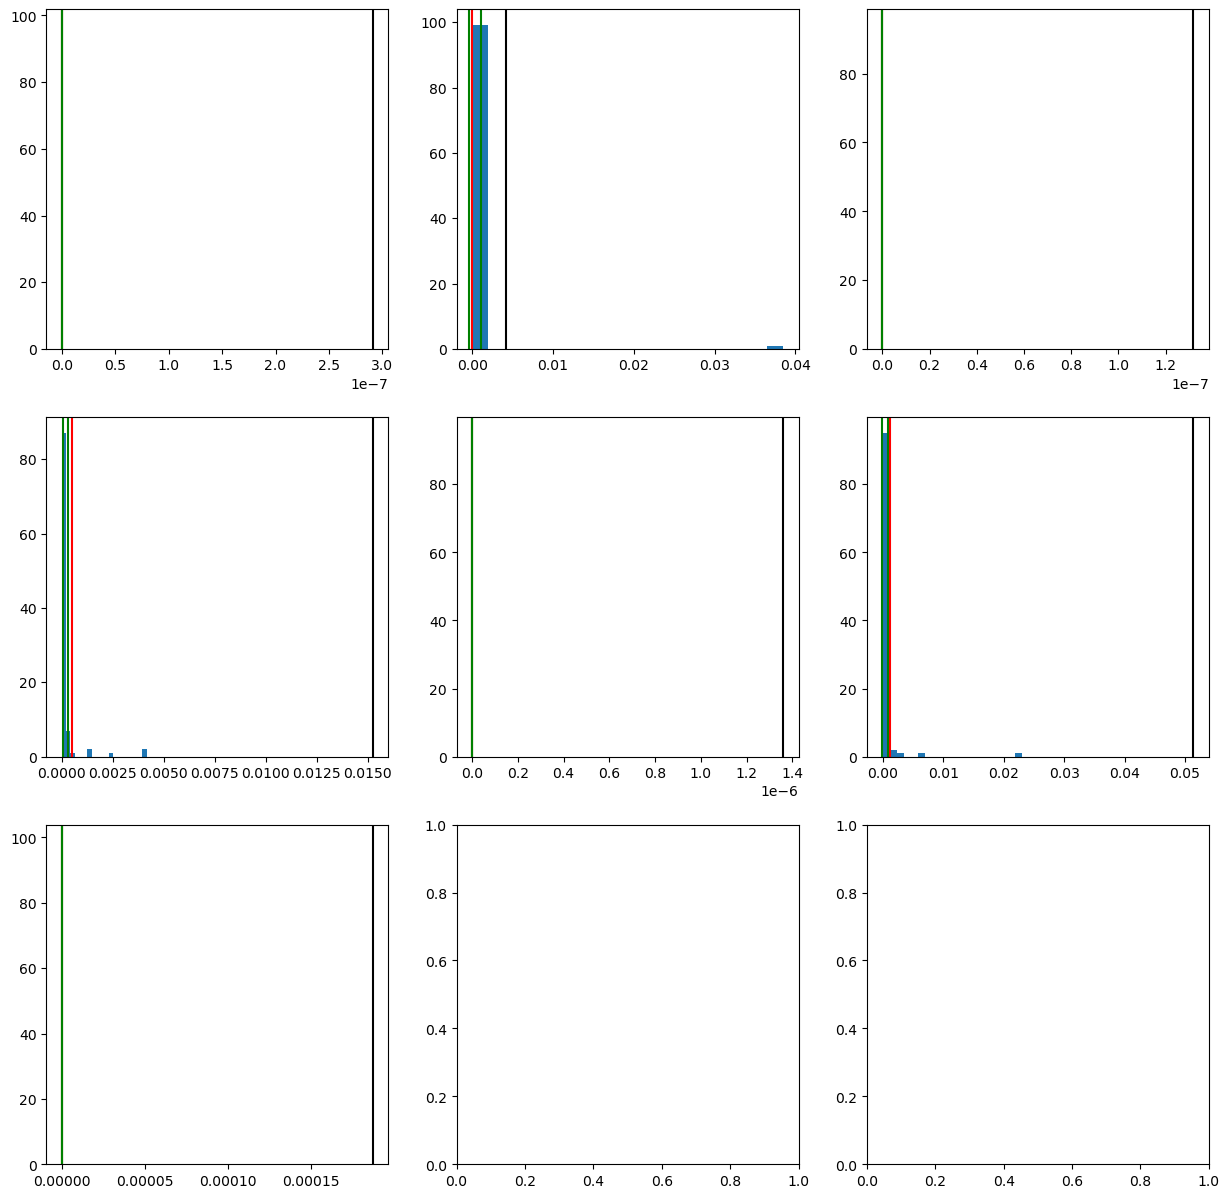

In [ ]:
frac_fixed_fig = plot_bootstrap_distributions([frac_fixed_gen, 
                                               frac_fixed_vis, frac_fixed_vis_no_gen, 
                                               frac_fixed_ori, frac_fixed_ori_no_gen,
                                               frac_fixed_dir, frac_fixed_dir_no_gen])
plt.show()

### Free Kruskal Wallis

In [92]:
# Do a Kruskal-Wallis test with Dunn posthoc

# General
frac_free_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'frac_vis_resp_free', 'direction_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls General 95% CI:', frac_free_gen[1][1])
print('Free vs Controls General Raw:', frac_free_gen[0])

# Visual
frac_free_vis = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                  'frac_vis_resp_free', 'direction_no_gen',
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Visual 95% CI:', frac_free_vis[1][1])
print('Free vs Controls Visual Raw:', frac_free_vis[0])

frac_free_vis_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                         'frac_vis_resp_free', 'direction_no_gen',
                                         kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Visual No Gen 95% CI:', frac_free_vis_no_gen[1][1])
print('Free vs Controls Visual No Gen Raw:', frac_free_vis_no_gen[0])

# Orientation
frac_free_ori = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                  'frac_vis_resp_free', 'direction_no_gen',
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Orientation 95% CI:', frac_free_ori[1][1])
print('Free vs Controls Orientation Raw:', frac_free_ori[0])

frac_free_ori_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                         'frac_vis_resp_free', 'direction_no_gen',
                                         kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Orientation No Gen 95% CI:', frac_free_ori_no_gen[1][1])
print('Free vs Controls Orientation No Gen Raw:', frac_free_ori_no_gen[0])

# Direction
frac_free_dir = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                  'frac_vis_resp_free', 'direction_no_gen',
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Direction 95% CI:', frac_free_dir[1][1])
print('Free vs Controls Direction Raw:', frac_free_dir[0])

frac_free_dir_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                         'frac_vis_resp_free', 'direction_no_gen',
                                          kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Direction No Gen 95% CI:', frac_free_dir_no_gen[1][1])
print('Free vs Controls Direction No Gen Raw:', frac_free_dir_no_gen[0])


Free vs Controls General 95% CI: (8.378312098408917e-17, 2.2219369626591414e-15)
Free vs Controls General Raw: (0.0005732679911785998,           1         2         3
1  1.000000  0.011727  0.007167
2  0.011727  1.000000  1.000000
3  0.007167  1.000000  1.000000)
Free vs Controls Visual 95% CI: (-1.4550063037535638e-12, 4.619965743176848e-12)
Free vs Controls Visual Raw: (0.0005732679911785998,           1         2         3
1  1.000000  0.011727  0.007167
2  0.011727  1.000000  1.000000
3  0.007167  1.000000  1.000000)
Free vs Controls Visual No Gen 95% CI: (1.6529067824090486e-16, 9.390637770731553e-16)
Free vs Controls Visual No Gen Raw: (0.0005732679911785998,           1         2         3
1  1.000000  0.011727  0.007167
2  0.011727  1.000000  1.000000
3  0.007167  1.000000  1.000000)
Free vs Controls Orientation 95% CI: (-3.766275697441962e-15, 1.2751099662472536e-14)
Free vs Controls Orientation Raw: (0.0005732679911785998,           1         2         3
1  1.000000  0.011727

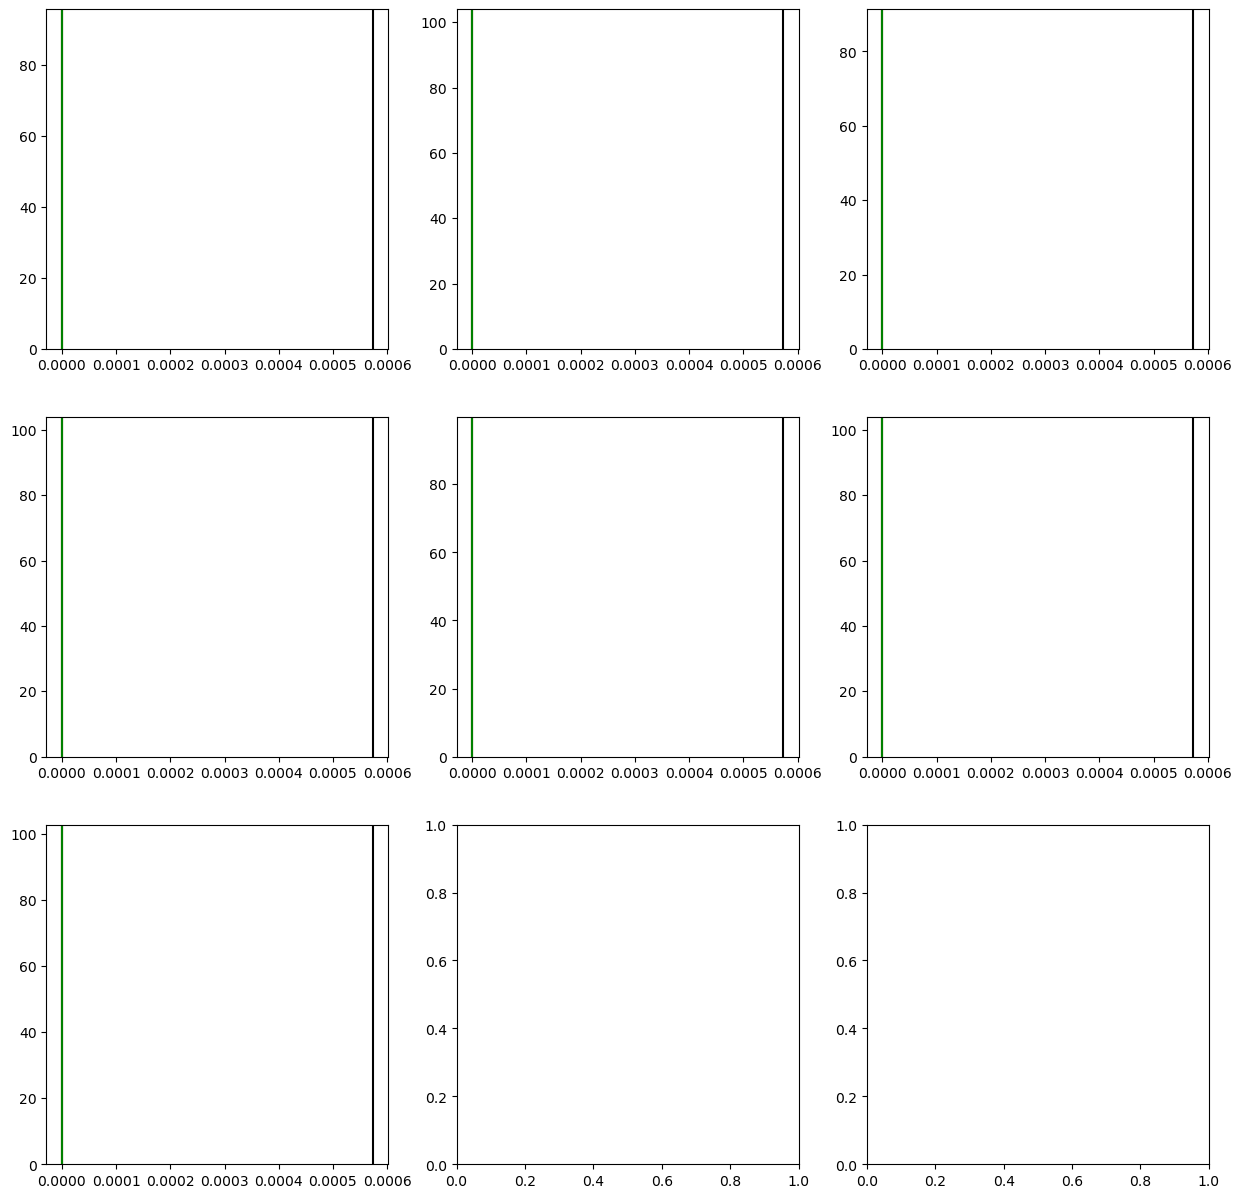

In [93]:
frac_free_fig = plot_bootstrap_distributions([frac_free_gen, 
                                              frac_free_vis, frac_free_vis_no_gen, 
                                              frac_free_ori, frac_free_ori_no_gen,
                                              frac_free_dir, frac_free_dir_no_gen])
plt.show()

## Count Vis Tuning - Fixed vs Free

### Kruskal-Wallis

In [67]:
# Do a Kruskal-Wallis test with posthoc Dunn test for multiple comparisons

# General
exp_fixed_free_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].general, 
                                              main_exp_data['count_vis_resp_free'].general))
print('Fixed vs Free General:', exp_fixed_free_gen)

# Visual
exp_fixed_free_vis = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].visual, 
                                              main_exp_data['count_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_vis_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].visual_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].visual_no_gen))
print('Fixed vs Free Visual No Gen:', exp_fixed_free_vis_no_gen)

exp_fixed_vis_vis_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].visual, 
                                                    main_exp_data['count_vis_resp_fixed'].visual_no_gen))
print('Fixed Visual - Visual No Gen:', exp_fixed_vis_vis_no_gen)

exp_free_vis_vis_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_free'].visual, 
                                                   main_exp_data['count_vis_resp_free'].visual_no_gen))
print('Free Visual - Visual No Gen:', exp_free_vis_vis_no_gen)

# Orientation
exp_fixed_free_ori = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].orientation, 
                                              main_exp_data['count_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_ori_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].orientation_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].orientation_no_gen))
print('Fixed vs Free Orientation No Gen:', exp_fixed_free_ori_no_gen)

exp_fixed_ori_ori_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].orientation, 
                                                    main_exp_data['count_vis_resp_fixed'].orientation_no_gen))
print('Fixed Orientation - Orientation No Gen:', exp_fixed_ori_ori_no_gen)

exp_free_ori_ori_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_free'].orientation, 
                                                    main_exp_data['count_vis_resp_free'].orientation_no_gen))
print('Free Orientation - Orientation No Gen:', exp_free_ori_ori_no_gen)

# Direction
exp_fixed_free_dir = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].direction, 
                                              main_exp_data['count_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

exp_fixed_free_dir_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].direction_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].direction_no_gen))
print('Fixed vs Free Direction No Gen:', exp_fixed_free_dir_no_gen)

exp_fixed_dir_dir_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_fixed'].direction, 
                                                    main_exp_data['count_vis_resp_fixed'].direction_no_gen))
print('Fixed Direction - Direction No Gen:', exp_fixed_dir_dir_no_gen)

exp_free_dir_dir_no_gen = kruskal_w_dunn(sample_df(main_exp_data['count_vis_resp_free'].direction, 
                                                    main_exp_data['count_vis_resp_free'].direction_no_gen))
print('Free Direction - Direction No Gen:', exp_free_dir_dir_no_gen)

Fixed vs Free General: (0.000532523542067895,           1         2
1  1.000000  0.000533
2  0.000533  1.000000)
Fixed vs Free Visual: (0.0028508853390493234,           1         2
1  1.000000  0.002851
2  0.002851  1.000000)
Fixed vs Free Visual No Gen: (0.0035598668385090713,          1        2
1  1.00000  0.00356
2  0.00356  1.00000)
Fixed Visual - Visual No Gen: (0.019270873187413825,           1         2
1  1.000000  0.019271
2  0.019271  1.000000)
Free Visual - Visual No Gen: (3.4755951846550804e-15,               1             2
1  1.000000e+00  3.475595e-15
2  3.475595e-15  1.000000e+00)
Fixed vs Free Orientation: (0.6954574747356317,           1         2
1  1.000000  0.695457
2  0.695457  1.000000)
Fixed vs Free Orientation No Gen: (0.0035962555917527167,           1         2
1  1.000000  0.003596
2  0.003596  1.000000)
Fixed Orientation - Orientation No Gen: (0.15653450537237454,           1         2
1  1.000000  0.156535
2  0.156535  1.000000)
Free Orientation - Orienta

### Wilcoxon Rank Sum

In [ ]:
# Do a Wilcox Rank-Sum test with Bonferroni correction

# General
exp_fixed_free_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].general, 
                                              main_exp_data['count_vis_resp_free'].general))
print('Fixed vs Free General:', exp_fixed_free_gen)

# Visual
exp_fixed_free_vis = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].visual, 
                                              main_exp_data['count_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_vis_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].visual_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].visual_no_gen))
print('Fixed vs Free Visual No Gen:', exp_fixed_free_vis_no_gen)

exp_fixed_vis_vis_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].visual, 
                                                    main_exp_data['count_vis_resp_fixed'].visual_no_gen))
print('Fixed Visual - Visual No Gen:', exp_fixed_vis_vis_no_gen)

exp_free_vis_vis_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_free'].visual, 
                                                   main_exp_data['count_vis_resp_free'].visual_no_gen))
print('Free Visual - Visual No Gen:', exp_free_vis_vis_no_gen)

# Orientation
exp_fixed_free_ori = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].orientation, 
                                              main_exp_data['count_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_ori_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].orientation_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].orientation_no_gen))
print('Fixed vs Free Orientation No Gen:', exp_fixed_free_ori_no_gen)

exp_fixed_ori_ori_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].orientation, 
                                                    main_exp_data['count_vis_resp_fixed'].orientation_no_gen))
print('Fixed Orientation - Orientation No Gen:', exp_fixed_ori_ori_no_gen)

exp_free_ori_ori_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_free'].orientation, 
                                                    main_exp_data['count_vis_resp_free'].orientation_no_gen))
print('Free Orientation - Orientation No Gen:', exp_free_ori_ori_no_gen)

# Direction
exp_fixed_free_dir = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].direction, 
                                              main_exp_data['count_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

exp_fixed_free_dir_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].direction_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].direction_no_gen))
print('Fixed vs Free Direction No Gen:', exp_fixed_free_dir_no_gen)

exp_fixed_dir_dir_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].direction, 
                                                    main_exp_data['count_vis_resp_fixed'].direction_no_gen))
print('Fixed Direction - Direction No Gen:', exp_fixed_dir_dir_no_gen)

exp_free_dir_dir_no_gen = wilcoxon_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_free'].direction, 
                                                    main_exp_data['count_vis_resp_free'].direction_no_gen))
print('Free Direction - Direction No Gen:', exp_free_dir_dir_no_gen)

### Mann-Whitney U

In [ ]:
# Do a Mann-Whitney U test with Bonferroni correction

# General
exp_fixed_free_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].general, 
                                              main_exp_data['count_vis_resp_free'].general))
print('Fixed vs Free General:', exp_fixed_free_gen)

# Visual
exp_fixed_free_vis = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].visual, 
                                              main_exp_data['count_vis_resp_free'].visual))
print('Fixed vs Free Visual:', exp_fixed_free_vis)

exp_fixed_free_vis_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].visual_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].visual_no_gen))
print('Fixed vs Free Visual No Gen:', exp_fixed_free_vis_no_gen)

exp_fixed_vis_vis_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].visual, 
                                                    main_exp_data['count_vis_resp_fixed'].visual_no_gen))
print('Fixed Visual - Visual No Gen:', exp_fixed_vis_vis_no_gen)

exp_free_vis_vis_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_free'].visual, 
                                                   main_exp_data['count_vis_resp_free'].visual_no_gen))
print('Free Visual - Visual No Gen:', exp_free_vis_vis_no_gen)

# Orientation
exp_fixed_free_ori = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].orientation, 
                                              main_exp_data['count_vis_resp_free'].orientation))
print('Fixed vs Free Orientation:', exp_fixed_free_ori)

exp_fixed_free_ori_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].orientation_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].orientation_no_gen))
print('Fixed vs Free Orientation No Gen:', exp_fixed_free_ori_no_gen)

exp_fixed_ori_ori_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].orientation, 
                                                    main_exp_data['count_vis_resp_fixed'].orientation_no_gen))
print('Fixed Orientation - Orientation No Gen:', exp_fixed_ori_ori_no_gen)

exp_free_ori_ori_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_free'].orientation, 
                                                    main_exp_data['count_vis_resp_free'].orientation_no_gen))
print('Free Orientation - Orientation No Gen:', exp_free_ori_ori_no_gen)

# Direction
exp_fixed_free_dir = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].direction, 
                                              main_exp_data['count_vis_resp_free'].direction))
print('Fixed vs Free Direction:', exp_fixed_free_dir)

exp_fixed_free_dir_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].direction_no_gen, 
                                                     main_exp_data['count_vis_resp_free'].direction_no_gen))
print('Fixed vs Free Direction No Gen:', exp_fixed_free_dir_no_gen)

exp_fixed_dir_dir_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_fixed'].direction, 
                                                    main_exp_data['count_vis_resp_fixed'].direction_no_gen))
print('Fixed Direction - Direction No Gen:', exp_fixed_dir_dir_no_gen)

exp_free_dir_dir_no_gen = mannwhitneyu_w_bonferroni(*sample_df(main_exp_data['count_vis_resp_free'].direction, 
                                                    main_exp_data['count_vis_resp_free'].direction_no_gen))
print('Free Direction - Direction No Gen:', exp_free_dir_dir_no_gen)

## Count Vis Tuning - Exp vs Controls
Try with bootstrapping

### Fixed

In [ ]:
# Do a Kruskal-Wallis test with Dunn posthoc

# General
count_fixed_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'count_vis_resp_fixed', 'general',   
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls General 95% CI:', count_fixed_gen[1][1])
print('Fixed vs Controls General Raw:', count_fixed_gen[0])

# Visual
count_fixed_vis = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'count_vis_resp_fixed', 'visual',   
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Visual 95% CI:', count_fixed_vis[1][1])
print('Fixed vs Controls Visual Raw:', count_fixed_vis[0])

count_fixed_vis_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'count_vis_resp_fixed', 'visual_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Visual No Gen 95% CI:', count_fixed_vis_no_gen[1][1])
print('Fixed vs Controls Visual No Gen Raw:', count_fixed_vis_no_gen[0])

# Orientation
count_fixed_ori = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'count_vis_resp_fixed', 'orientation',
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Orientation 95% CI:', count_fixed_ori[1][1])
print('Fixed vs Controls Orientation Raw:', count_fixed_ori[0])

count_fixed_ori_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'count_vis_resp_fixed', 'orientation_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Orientation No Gen 95% CI:', count_fixed_ori_no_gen[1][1])
print('Fixed vs Controls Orientation No Gen Raw:', count_fixed_ori_no_gen[0])


# Direction
count_fixed_dir = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                 'count_vis_resp_fixed', 'direction',
                                 kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Direction 95% CI:', count_fixed_dir[1][1])
print('Fixed vs Controls Direction Raw:', count_fixed_dir[0])

count_fixed_dir_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'count_vis_resp_fixed', 'direction_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Fixed vs Controls Direction No Gen 95% CI:', count_fixed_dir_no_gen[1][1])
print('Fixed vs Controls Direction No Gen Raw:', count_fixed_dir_no_gen[0])


# # Plot the bootstrap distributions
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].hist(bs_count_fixed_exp_control_light_vis[0], bins=20)
# ax[0].axvline(np.percentile(bs_count_fixed_exp_control_light_vis[0], 50), 0, 100, color='r')
# ax[0].axvline(count_fixed_exp_control_light_vis[2], 0, 100, color='k')
# ax[0].axvline(bs_count_fixed_exp_control_light_vis[1][0], 0, 100, color='g')
# ax[0].axvline(bs_count_fixed_exp_control_light_vis[1][1], 0, 100, color='g')

# ax[1].hist(bs_count_fixed_exp_control_light_ori[0], bins=20)
# ax[1].axvline(np.percentile(bs_count_fixed_exp_control_light_ori[0], 50), 0, 100, color='r')
# ax[1].axvline(count_fixed_exp_control_light_ori[2], 0, 100, color='k')
# ax[1].axvline(bs_count_fixed_exp_control_light_ori[1][0], 0, 100, color='g')
# ax[1].axvline(bs_count_fixed_exp_control_light_ori[1][1], 0, 100, color='g')

# ax[2].hist(bs_count_fixed_exp_control_light_dir[0], bins=20)
# ax[2].axvline(np.percentile(bs_count_fixed_exp_control_light_dir[0], 50), 0, 100, color='r')
# ax[2].axvline(count_fixed_exp_control_light_dir[2], 0, 100, color='k')
# ax[2].axvline(bs_count_fixed_exp_control_light_dir[1][0], 0, 100, color='g')
# ax[2].axvline(bs_count_fixed_exp_control_light_dir[1][1], 0, 100, color='g')

In [ ]:
# Exp vs control dark
count_fixed_exp_control_dark_vis, bs_count_fixed_exp_control_dark_vis = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Fixed vs Control Dark Visual p:', count_fixed_exp_control_dark_vis)
print('Fixed vs Control Dark Visual Bootstrap CI:', bs_count_fixed_exp_control_dark_vis[1])

count_fixed_exp_control_dark_ori , bs_count_fixed_exp_control_dark_ori = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Fixed vs Control Dark Orientation p:', count_fixed_exp_control_dark_ori)
print('Fixed vs Control Dark Orientation Bootstrap CI:', bs_count_fixed_exp_control_dark_ori[1])

count_fixed_exp_control_dark_dir, bs_count_fixed_exp_control_dark_dir = run_bootstrap_tests(main_exp_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Fixed vs Control Dark Direction p:', count_fixed_exp_control_dark_dir)
print('Fixed vs Control Dark Direction Bootstrap CI:', bs_count_fixed_exp_control_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_fixed_exp_control_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_fixed_exp_control_dark_vis[0], 99), 0, 100, color='r')
ax[0].axvline(count_fixed_exp_control_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_fixed_exp_control_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_fixed_exp_control_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_fixed_exp_control_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_fixed_exp_control_dark_ori[0], 99), 0, 100, color='r')
ax[1].axvline(count_fixed_exp_control_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_fixed_exp_control_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_fixed_exp_control_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_fixed_exp_control_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_fixed_exp_control_dark_dir[0], 99), 0, 100, color='r')
ax[2].axvline(count_fixed_exp_control_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_fixed_exp_control_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_fixed_exp_control_dark_dir[1][1], 0, 100, color='g')

In [ ]:
# Control light vs control dark
count_fixed_control_light_dark_vis, bs_count_fixed_control_light_dark_vis = run_bootstrap_tests(control_light_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].visual.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)

print('Control Light vs Control Dark Visual p:', count_fixed_control_light_dark_vis)
print('Control Light vs Control Dark Visual Bootstrap CI:', bs_count_fixed_control_light_dark_vis[1])

count_fixed_control_light_dark_ori , bs_count_fixed_control_light_dark_ori = run_bootstrap_tests(control_light_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].orientation.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Orientation p:', count_fixed_control_light_dark_ori)
print('Control Light vs Control Dark Orientation Bootstrap CI:', bs_count_fixed_control_light_dark_ori[1])

count_fixed_control_light_dark_dir, bs_count_fixed_control_light_dark_dir = run_bootstrap_tests(control_light_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            control_dark_data['count_vis_resp_fixed'].direction.dropna(), 
                                                                                            method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Direction p:', count_fixed_control_light_dark_dir)
print('Control Light vs Control Dark Direction Bootstrap CI:', bs_count_fixed_control_light_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_fixed_control_light_dark_dir[0], bins=20)
ax[0].axvline(np.percentile(bs_count_fixed_control_light_dark_dir[0], 95), 0, 100, color='r')
ax[0].axvline(count_fixed_control_light_dark_vis[2][-1], 0, 100, color='k')
ax[0].axvline(bs_count_fixed_control_light_dark_dir[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_fixed_control_light_dark_dir[1][1], 0, 100, color='g')

ax[1].hist(bs_count_fixed_control_light_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_fixed_control_light_dark_ori[0], 95), 0, 100, color='r')
ax[1].axvline(count_fixed_control_light_dark_ori[2][-1], 0, 100, color='k')
ax[1].axvline(bs_count_fixed_control_light_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_fixed_control_light_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_fixed_control_light_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_fixed_control_light_dark_dir[0], 95), 0, 100, color='r')
ax[2].axvline(count_fixed_control_light_dark_dir[2][-1], 0, 100, color='k')
ax[2].axvline(bs_count_fixed_control_light_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_fixed_control_light_dark_dir[1][1], 0, 100, color='g')

### Free

In [ ]:
# Do a Kruskal-Wallis test with Dunn posthoc

# General
count_free_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                        'count_vis_resp_free', 'direction_no_gen',
                                        kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls General 95% CI:', count_free_gen[1][1])
print('Free vs Controls General Raw:', count_free_gen[0])

# Visual
count_free_vis = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                  'count_vis_resp_free', 'direction_no_gen',
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Visual 95% CI:', count_free_vis[1][1])
print('Free vs Controls Visual Raw:', count_free_vis[0])

count_free_vis_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                         'count_vis_resp_free', 'direction_no_gen',
                                         kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Visual No Gen 95% CI:', count_free_vis_no_gen[1][1])
print('Free vs Controls Visual No Gen Raw:', count_free_vis_no_gen[0])

# Orientation
count_free_ori = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                  'count_vis_resp_free', 'direction_no_gen',
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Orientation 95% CI:', count_free_ori[1][1])
print('Free vs Controls Orientation Raw:', count_free_ori[0])

count_free_ori_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                         'count_vis_resp_free', 'direction_no_gen',
                                         kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Orientation No Gen 95% CI:', count_free_ori_no_gen[1][1])
print('Free vs Controls Orientation No Gen Raw:', count_free_ori_no_gen[0])

# Direction
count_free_dir = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                  'count_vis_resp_free', 'direction_no_gen',
                                  kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Direction 95% CI:', count_free_dir[1][1])
print('Free vs Controls Direction Raw:', count_free_dir[0])

count_free_dir_no_gen = bootstrap_tests([main_exp_data, control_light_data, control_dark_data],
                                         'count_vis_resp_free', 'direction_no_gen',
                                          kruskal_w_dunn, n_iters=bootstrap_iters, bootstrap_all=True)
print('Free vs Controls Direction No Gen 95% CI:', count_free_dir_no_gen[1][1])
print('Free vs Controls Direction No Gen Raw:', count_free_dir_no_gen[0])


# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_free_exp_control_light_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_free_exp_control_light_vis[0], 50), 0, 100, color='r')
ax[0].axvline(count_free_exp_control_light_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_free_exp_control_light_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_free_exp_control_light_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_free_exp_control_light_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_free_exp_control_light_ori[0], 50), 0, 100, color='r')
ax[1].axvline(count_free_exp_control_light_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_free_exp_control_light_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_free_exp_control_light_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_free_exp_control_light_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_free_exp_control_light_dir[0], 50), 0, 100, color='r')
ax[2].axvline(count_free_exp_control_light_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_free_exp_control_light_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_free_exp_control_light_dir[1][1], 0, 100, color='g')

In [ ]:
# Exp vs control dark
count_free_exp_control_dark_vis, bs_count_free_exp_control_dark_vis = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Visual p:', count_free_exp_control_dark_vis)
print('Free vs Control Dark Visual Bootstrap CI:', bs_count_free_exp_control_dark_vis[1])

count_free_exp_control_dark_ori , bs_count_free_exp_control_dark_ori = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           control_dark_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Orientation p:', count_free_exp_control_dark_ori)
print('Free vs Control Dark Orientation Bootstrap CI:', bs_count_free_exp_control_dark_ori[1])

count_free_exp_control_dark_dir, bs_count_free_exp_control_dark_dir = run_bootstrap_tests(main_exp_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Free vs Control Dark Direction p:', count_free_exp_control_dark_dir)
print('Free vs Control Dark Direction Bootstrap CI:', bs_count_free_exp_control_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_free_exp_control_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_free_exp_control_dark_vis[0], 99), 0, 100, color='r')
ax[0].axvline(count_free_exp_control_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_free_exp_control_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_free_exp_control_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_free_exp_control_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_free_exp_control_dark_ori[0], 99), 0, 100, color='r')
ax[1].axvline(count_free_exp_control_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_free_exp_control_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_free_exp_control_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_free_exp_control_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_free_exp_control_dark_dir[0], 99), 0, 100, color='r')
ax[2].axvline(count_free_exp_control_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_free_exp_control_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_free_exp_control_dark_dir[1][1], 0, 100, color='g')

In [ ]:
# Control light vs control dark
count_free_control_light_dark_vis, bs_count_free_control_light_dark_vis = run_bootstrap_tests(control_light_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].visual.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Visual p:', count_free_control_light_dark_vis)
print('Control Light vs Control Dark Visual Bootstrap CI:', bs_count_free_control_light_dark_vis[1])

count_free_control_light_dark_ori , bs_count_free_control_light_dark_ori = run_bootstrap_tests(control_light_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           control_dark_data['count_vis_resp_free'].orientation.dropna(), 
                                                                                           method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Orientation p:', count_free_control_light_dark_ori)
print('Control Light vs Control Dark Orientation Bootstrap CI:', bs_count_free_control_light_dark_ori[1])

count_free_control_light_dark_dir, bs_count_free_control_light_dark_dir = run_bootstrap_tests(control_light_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          control_dark_data['count_vis_resp_free'].direction.dropna(), 
                                                                                          method, n_iters=bootstrap_iters, bootstrap_both=False)
print('Control Light vs Control Dark Direction p:', count_free_control_light_dark_dir)
print('Control Light vs Control Dark Direction Bootstrap CI:', bs_count_free_control_light_dark_dir[1])

# Plot the bootstrap distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(bs_count_free_control_light_dark_vis[0], bins=20)
ax[0].axvline(np.percentile(bs_count_free_control_light_dark_vis[0], 99), 0, 100, color='r')
ax[0].axvline(count_free_control_light_dark_vis[2], 0, 100, color='k')
ax[0].axvline(bs_count_free_control_light_dark_vis[1][0], 0, 100, color='g')
ax[0].axvline(bs_count_free_control_light_dark_vis[1][1], 0, 100, color='g')

ax[1].hist(bs_count_free_control_light_dark_ori[0], bins=20)
ax[1].axvline(np.percentile(bs_count_free_control_light_dark_ori[0], 99), 0, 100, color='r')
ax[1].axvline(count_free_control_light_dark_ori[2], 0, 100, color='k')
ax[1].axvline(bs_count_free_control_light_dark_ori[1][0], 0, 100, color='g')
ax[1].axvline(bs_count_free_control_light_dark_ori[1][1], 0, 100, color='g')

ax[2].hist(bs_count_free_control_light_dark_dir[0], bins=20)
ax[2].axvline(np.percentile(bs_count_free_control_light_dark_dir[0], 99), 0, 100, color='r')
ax[2].axvline(count_free_control_light_dark_dir[2], 0, 100, color='k')
ax[2].axvline(bs_count_free_control_light_dark_dir[1][0], 0, 100, color='g')
ax[2].axvline(bs_count_free_control_light_dark_dir[1][1], 0, 100, color='g')

# Kinematic Tuning - Experiment vs Controls

In [ ]:
def kinem_stats(data1, data2, alpha=0.05):
    cols = data1.columns.to_list()

    stats = {}
    for col in cols:
        stats[col] = kruskal_w_dunn((data1[col], data2[col]), alpha=alpha)

    return stats

## Fixed

In [ ]:
# Exp vs control light
fixed_exp_control_light_kinem = kinem_stats(main_exp_data['frac_kinem_resp_fixed'], control_light_data['frac_kinem_resp_fixed'])
print(fixed_exp_control_light_kinem)

# Exp vs control dark
fixed_exp_control_dark_kinem = kinem_stats(main_exp_data['frac_kinem_resp_fixed'], control_dark_data['frac_kinem_resp_fixed'])
print(fixed_exp_control_dark_kinem)

# Control light vs control dark
fixed_control_light_dark_kinem = kinem_stats(control_light_data['frac_kinem_resp_fixed'], control_dark_data['frac_kinem_resp_fixed'])
print(fixed_control_light_dark_kinem)

In [ ]:
fixed_exp_control_light_kinem

## Free

In [ ]:
# Exp vs control light
free_exp_control_light_kinem = kinem_stats(main_exp_data['frac_kinem_resp_free'], control_light_data['frac_kinem_resp_free'])

# Exp vs control dark
free_exp_control_dark_kinem = kinem_stats(main_exp_data['frac_kinem_resp_free'], control_dark_data['frac_kinem_resp_free'])

# Control light vs control dark
free_control_light_dark_kinem = kinem_stats(control_light_data['frac_kinem_resp_free'], control_dark_data['frac_kinem_resp_free'])

In [ ]:
free_control_light_dark_kinem